In [1]:
import os  

os.environ["MLFLOW_ENABLE_SYSTEM_METRICS_LOGGING"] = "true"

# run below for local tracking: (see https://mlflow.org/docs/latest/getting-started/intro-quickstart/)
# use whatever port is not being used
# > mlflow server --host 127.0.0.1 --port 8080
os.environ["MLFLOW_TRACKING_URI"] = "http://127.0.0.1:8080" # or whatever port you use above


from mlflow import MlflowClient

from mlflow.server import get_app_client
import mlflow.pytorch
import mlflow.keras
import mlflow
from mlflow.models import infer_signature

import matplotlib.pyplot as plt

import keras
import torch

import numpy as np
import pandas as pd

mlflow.set_experiment("my-experiment") # change the name of the experiment to your liking


# some data for us to play with
data_X = np.random.uniform(-1, 1, (1000, 2))
data_y = np.max(data_X, axis=1)

2025/04/17 17:05:38 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2025/04/17 17:05:38 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.
2025/04/17 17:05:38 INFO mlflow.types.utils: MLflow 2.9.0 introduces model signature with new data types for lists and dictionaries. For input such as Dict[str, Union[scalars, List, Dict]], we infer dictionary values types as `List -> Array` and `Dict -> Object`. 
2025/04/17 17:05:39 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-02-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'lume-model'}
2025/04/17 17:05:39 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the

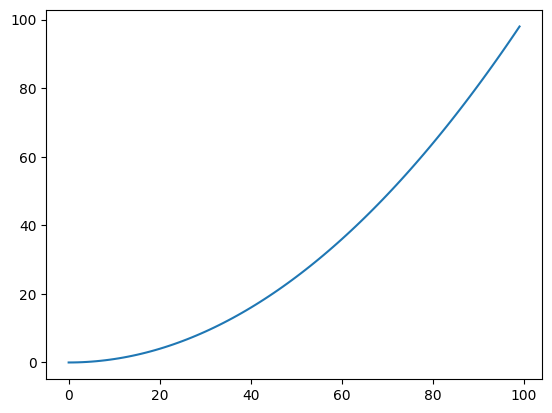

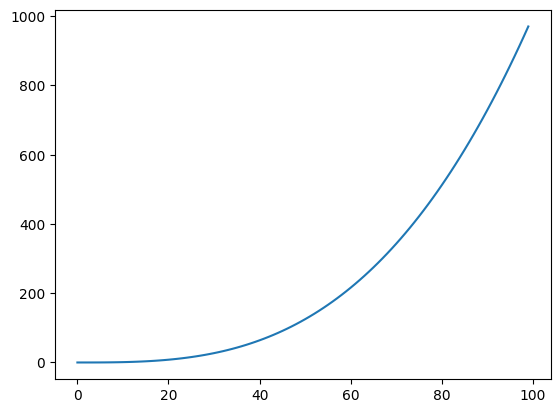

In [2]:
### GENERIC MODEL EXAMPLE

from model_definition import ExampleModel
from lume_model.variables import ScalarVariable


# basic wrapper we use to take advantage of mlflow logging
class MyModel(mlflow.pyfunc.PythonModel):
    def __init__(self, model_name, model):
        self.model_name = model_name
        self.model = model
    
    def predict(self, context, input, **kwargs):
        input = {col: input[col].to_numpy().reshape(-1,1) for col in input.columns}
        #print(input)
        return self.model.evaluate(input)
    
    def save_model(self):
        with open(f"{self.model_name}.txt", "w") as f:
            f.write("model saved")

    def load_model(self):
        with open(f"{self.model_name}.txt", "r") as f:
            return f.read()
        
    def get_lume_model(self): # define this function to get deployment to work
        return self.model
    


# lume-model example, we need to define it in a separate file and import it due to jupyternotebook namespace issues

####################################################### MODEL DEFINITION ########################################################
#
# from lume_model.base import LUMEBaseModel
#
# import numpy as np
#
# class ExampleModel(LUMEBaseModel):
#     def evaluate(self, input_dict):
#         output_dict = {}
#         output_dict["y"] = np.max([input_dict["x1"], input_dict["x2"]])
#         return output_dict
#
#
##################################################################################################################################

input_variables = [ScalarVariable(name = "x1", default_value=0, value_range=[-100000, 1000000]), ScalarVariable(name = "x2", default_value=0, value_range=[-100000, 1000000])]
output_variables = [ScalarVariable(name = "y")]
lume_model = ExampleModel(input_variables = input_variables, output_variables = output_variables)
model = MyModel("model1", lume_model)

input_sample = pd.DataFrame(data_X, columns=["x1", "x2"])

with mlflow.start_run() as run:  # you can use run_name="test1" to give a name to the run otherwise it will a random name

    
    # set some tags for the experiment
    mlflow.set_tag("exp_tag1", "exp_tag_value1")
    mlflow.set_tag("exp_tag2", "exp_tag_value2")
    mlflow.set_tag("exp_tag3", "exp_tag_value3")
    
    # model.save_model() # no need to save the model since it is saved in log_model
    mlflow.log_param("model_name", model.model_name)
    mlflow.log_param("dummy_param1", "dummy_value1")
    mlflow.log_param("dummy_param2", 0.33)
    for i in range(10):        
        mlflow.log_metric("metric1", (i / 10) ** 2 , step=i)
        mlflow.log_metric("metric2", (i / 10) ** 3 , step=i)
        mlflow.log_metric("loss", (1 / (i + 0.1) + np.random.normal(0, 0.1)) , step=i)

    # lets make some pretty graphs to store

    graph = plt.figure()
    plt.plot(range(100), [(i / 10) ** 2 for i in range(100)])
    mlflow.log_figure(graph, "figures/metric1.png")

    # alternative way to log a figure
    graph = plt.figure()
    plt.plot(range(100), [(i / 10) ** 3 for i in range(100)])
    graph.savefig("metric2.png")
    mlflow.log_artifact("metric2.png", artifact_path="figures")
    
    model_info = mlflow.pyfunc.log_model(
        artifact_path="model_files",
        python_model=model,
        signature=infer_signature(input_sample, model.predict(None, input = input_sample)),
        input_example=input_sample,
        code_path=["model_definition.py"],
        extra_pip_requirements=["paho-mqtt"] # example dependancy
        # registered_model_name="generic_model", # this will automatically register the model and iterate the version
     )

    # if you wanna log the model without the wrapper
    model.save_model()
    mlflow.log_artifact(
        f"{model.model_name}.txt", artifact_path="model_files_no_mlflow"
    )
    mlflow.log_artifact(
        f"./generic/pv_mapping.yaml", artifact_path="generic_model"
    )

In [3]:
import torch
from lume_model.models import TorchModel, TorchModule


# torch model 
base_torch = torch.nn.Sequential(
    torch.nn.Linear(2,64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 1),
)

# change initialisation
for layer in base_torch:
    if isinstance(layer, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(layer.weight)
        torch.nn.init.zeros_(layer.bias)
        layer.weight.data.fill_(0.05)
        layer.bias.data.fill_(0.05)
        

mlflow.pytorch.autolog()

with mlflow.start_run() as run:
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(base_torch.parameters(), lr=0.01)
    # log params
    mlflow.log_param("lr", 0.01)
    mlflow.log_param("optimizer", "Adam")
    mlflow.log_param("loss", "MSELoss")
    
    for t in range(20):

        X = torch.tensor(data_X, dtype=torch.float32)
        y = torch.tensor(data_y, dtype=torch.float32)
        y_pred = base_torch(X).flatten()
        loss = criterion(y_pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
            
        mlflow.log_metric("loss", np.mean(loss.detach().numpy()), step=t)
        print(t, np.mean(loss.detach().numpy()))
    
    mlflow.set_tag("tag1", "tag_value1")
    
    lume_torch = TorchModel(model = base_torch, input_variables = input_variables, output_variables = output_variables)

    model_torch = TorchModule(model = lume_torch)
    
    mlflow.log_artifact(
        f"torch/pv_mapping.yaml", artifact_path="torch_model"
    )
        
        
    signature = infer_signature(data_X, model_torch(torch.tensor(data_X, dtype=torch.float32)).detach().numpy()) # optional but useful

    model_info_torch = mlflow.pytorch.log_model(model_torch, "torch_model", signature=signature)

/Users/smiskov/miniconda3/envs/mlflow-updated/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025/04/17 17:05:41 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of pytorch. If you encounter errors during autologging, try upgrading / downgrading pytorch to a supported version, or try upgrading MLflow.
2025/04/17 17:05:41 WARNING mlflow.system_metrics.system_metrics_monitor: Skip logging GPU metrics because creating `GPUMonitor` failed with error: `pynvml` is not installed, to log GPU metrics please run `pip install pynvml` to install it..
2025/04/17 17:05:41 INFO mlflow.system_metrics.system_metrics_monitor: Started monitoring system metrics.


0 0.2496011
1 0.12000745
2 0.14692535
3 0.17227377
4 0.18028453
5 0.17326789
6 0.15451474
7 0.12920268
8 0.107688196
9 0.10500725
10 0.124109946
11 0.1356409
12 0.12181998
13 0.10245722
14 0.095314994
15 0.09966347
16 0.10697988
17 0.10947267
18 0.105408885
19 0.09677603


2025/04/17 17:05:43 WARNING mlflow.utils.requirements_utils: The following packages were not found in the public PyPI package index as of 2024-02-29; if these packages are not present in the public PyPI index, you must install them manually before loading your model: {'lume-model'}
2025/04/17 17:05:43 INFO mlflow.system_metrics.system_metrics_monitor: Stopping system metrics monitoring...
2025/04/17 17:05:43 INFO mlflow.system_metrics.system_metrics_monitor: Successfully terminated system metrics monitoring!


In [4]:
# specifc model uris
print(model_info.model_uri)
# print(model_info_keras.model_uri)
print(model_info_torch.model_uri)

# lets register the models if they are not already this step is necessary for deployment
client = MlflowClient()
try:
    client.create_registered_model("generic_model")
    
except:
    pass

# try:
#     client.create_registered_model("keras_model")
# except:
#     pass

try:
    client.create_registered_model("torch_model")
except:
    pass

# create new model versions

# str(dict_model)
result_generic = client.create_model_version(
    name="generic_model",
    source=model_info.model_uri,
    run_id=model_info.run_id,
    tags={"tests": "pending", "framework": "pyfunc"},
)


# result_keras = client.create_model_version(
#     name="keras_model",
#     source=model_info_keras.model_uri,
#     run_id=model_info_keras.run_id,
# )


result_torch = client.create_model_version(
    name="torch_model",
    source=model_info_torch.model_uri,
    run_id=model_info_torch.run_id,
)

client.set_registered_model_alias("generic_model", "challenger", result_generic.version)


client.set_registered_model_tag("generic_model", "deployment_publish", "false")
client.set_registered_model_tag("generic_model", "deployment_type", "continuous")


# do some tests
model_ver_champ = client.get_model_version_by_alias("generic_model", "challenger").version

# 99% of the time it will pass
if np.random.uniform() < 0.99:
    client.set_model_version_tag("generic_model", f"{model_ver_champ}", "tests", "passed")
    # set the champion model
    client.set_registered_model_alias("generic_model", "champion", result_generic.version)
else:
    client.set_model_version_tag("generic_model", f"{model_ver_champ}", "tests", "failed")
    print("model failed")

# client.set_registered_model_alias("keras_model", "champion", result_keras.version)
# # client.set_registered_model_tag("keras_model", "lattice_component", "DEF")
# # client.set_registered_model_tag("keras_model", "lume_service", "false")
# # client.set_registered_model_tag("keras_model", "lume_service_url", "")
# # client.set_registered_model_tag("keras_model", "deployment_type", "continuous")
# # client.set_registered_model_tag("keras_model", "multi_model_service", "false")
# # client.set_registered_model_tag("keras_model", "retrain", "false")
# # client.set_registered_model_tag("keras_model", "retrain_endpoint", "")

client.set_registered_model_alias("torch_model", "champion", result_torch.version)
client.set_registered_model_tag("torch_model", "deployment_type", "continuous")




2025/04/17 17:05:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: generic_model, version 3
2025/04/17 17:05:43 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: torch_model, version 3


runs:/f7ecbf320f9749c09deb51d8796e91fc/model_files
runs:/1932e033733f437fb91fa90a38937777/torch_model


In [5]:
# get model ids from registered models
genric_model  = mlflow.pyfunc.load_model(f"models:/generic_model@champion")
# keras_model = mlflow.keras.load_model(f"models:/keras_model@champion")
torch_model = mlflow.pytorch.load_model(f"models:/torch_model@champion")

# # get model info
print("Generic model")
print(genric_model, type(genric_model))
# print("Keras model")
# print(keras_model, type(keras_model)  
print("Torch model")
print(torch_model, type(torch_model))

# new_data = np.random.uniform(-1, 1, (20, 2))
# print(new_data)

# lets run some predictions

# print("Generic model")
# print(genric_model.predict(new_data))
# print("Keras model")
# print(keras_model.predict([new_data[:, 0], new_data[:, 1]]))


2025/04/17 17:05:44 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false   | 0/13 [00:00<?, ?it/s]
2025/04/17 17:05:44 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - paho-mqtt (current: uninstalled, required: paho-mqtt)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.
2025/04/17 17:05:44 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false   | 0/11 [00:00<?, ?it/s]

Generic model
mlflow.pyfunc.loaded_model:
  artifact_path: model_files
  flavor: mlflow.pyfunc.model
  run_id: f7ecbf320f9749c09deb51d8796e91fc
 <class 'mlflow.pyfunc.PyFuncModel'>
Torch model
TorchModule(
  (base_model): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
) <class 'lume_model.models.torch_module.TorchModule'>


In [6]:
!conda list

# packages in environment at /Users/smiskov/miniconda3/envs/mlflow-updated:
#
# Name                    Version                   Build  Channel
absl-py                   2.2.2                    pypi_0    pypi
alembic                   1.15.2                   pypi_0    pypi
annotated-types           0.7.0                    pypi_0    pypi
anyio                     4.6.2           py311hca03da5_0  
appnope                   0.1.2           py311hca03da5_1001  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0          py311h80987f9_1  
argparse                  1.4.0                    pypi_0    pypi
asttokens                 3.0.0           py311hca03da5_0  
astunparse                1.6.3                    pypi_0    pypi
async-lru                 2.0.4           py311hca03da5_0  
attrs                     24.3.0          py311hca03da5_0  
babel                     2.16.0          py311hca03da5_0  
beautifulsoup4            4.12.3          